In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [4]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=695704595703-kho1v4q5lhtoqq268ckb4it0n08facat.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
BTCUSDT_2020-01-02.json


C:\Users\user\Documents\GitHub\TradingBot\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

# Stage 0

In [5]:
dt = raw_data['BTCUSDT'][['open', 'high', 'low','close']].copy()
dt

,open,high,low,close
time,,,,
2020-01-01 00:00:00+00:00,7195.24,7196.25,7178.20,7191.07
2020-01-01 00:10:00+00:00,7193.15,7193.53,7177.35,7178.29
2020-01-01 00:20:00+00:00,7177.71,7185.56,7175.47,7178.45
2020-01-01 00:30:00+00:00,7178.19,7185.44,7176.23,7177.53
2020-01-01 00:40:00+00:00,7177.14,7182.99,7176.34,7182.94
...,...,...,...,...
2020-01-02 23:20:00+00:00,6959.16,6962.39,6950.00,6962.34
2020-01-02 23:30:00+00:00,6962.47,6974.75,6957.66,6965.37
2020-01-02 23:40:00+00:00,6965.09,6969.46,6959.87,6967.41


# Stage 1

In [6]:
dt1 = pd.DataFrame()
dt1['open'] = dt['open'].pct_change()
dt1['close'] = dt['close'].pct_change()
dt1 

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.000290,-0.001777
2020-01-01 00:20:00+00:00,-0.002146,0.000022
2020-01-01 00:30:00+00:00,0.000067,-0.000128
2020-01-01 00:40:00+00:00,-0.000146,0.000754
...,...,...
2020-01-02 23:20:00+00:00,-0.001664,0.000457
2020-01-02 23:30:00+00:00,0.000476,0.000435
2020-01-02 23:40:00+00:00,0.000376,0.000293


In [7]:
std_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
std_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()

cov_open_close = dt1.cov()
cov = cov_open_close.iloc[0, 1]
corr = cov / (std_close*std_open)

mean_close, std_close, mean_open, std_open, cov, corr, cov_open_close

(-0.00011071658288543273,
 0.0014098873357997598,
 -0.00011168703848396907,
 0.0014030332655430606,
 -1.8471211971044486e-07,
 -0.09337766601688922,
                open         close
 open   1.975361e-06 -1.847121e-07
 close -1.847121e-07  1.994708e-06)

# Stage 2

In [8]:
dt2 = pd.DataFrame()
dt2['open'] = (dt1['open'] - mean_open) / std_open
dt2['close'] = (dt1['close'] - mean_close) * 2*corr / std_close
dt2

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.127426,0.220745
2020-01-01 00:20:00+00:00,-1.450286,-0.017618
2020-01-01 00:30:00+00:00,0.127268,0.002311
2020-01-01 00:40:00+00:00,-0.024653,-0.114507
...,...,...
2020-01-02 23:20:00+00:00,-1.106465,-0.075194
2020-01-02 23:30:00+00:00,0.418607,-0.072313
2020-01-02 23:40:00+00:00,0.347811,-0.053461


# Stage 3

In [9]:
dt3 = dt2.copy()
dt3['close'] = dt3['open'] - dt3['close']
dt3

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.127426,-0.348171
2020-01-01 00:20:00+00:00,-1.450286,-1.432668
2020-01-01 00:30:00+00:00,0.127268,0.124957
2020-01-01 00:40:00+00:00,-0.024653,0.089854
...,...,...
2020-01-02 23:20:00+00:00,-1.106465,-1.031271
2020-01-02 23:30:00+00:00,0.418607,0.490919
2020-01-02 23:40:00+00:00,0.347811,0.401271


# Stage 4

In [10]:
chol = np.linalg.cholesky(dt3.corr())
inverse_chol = np.linalg.inv(chol)

# Stage 5

In [11]:
dt5 = np.matmul(inverse_chol, dt3.T).T # or np.matmul(dt3, inverse_chol.T)
dt5.columns = ['open', 'close']
dt5

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.127426,-1.199174
2020-01-01 00:20:00+00:00,-1.450286,-0.041260
2020-01-01 00:30:00+00:00,0.127268,-0.000492
2020-01-01 00:40:00+00:00,-0.024653,0.613537
...,...,...
2020-01-02 23:20:00+00:00,-1.106465,0.300644
2020-01-02 23:30:00+00:00,0.418607,0.428175
2020-01-02 23:40:00+00:00,0.347811,0.320144


# Stage 6

In [12]:
transform = dt5.copy()

In [13]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

((2, 0, 0), (0, 0, 0, 1), (2, 0, 0), (0, 0, 0, 1))

In [14]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

In [15]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(transform), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(transform), 1)
t_open, t_close

(            0
 0   -0.137662
 1    0.704559
 2   -0.470258
 3   -0.516564
 4   -0.576349
 ..        ...
 284 -0.026299
 285 -0.700252
 286  0.154434
 287 -0.130136
 288 -0.107519
 
 [289 rows x 1 columns],
             0
 0    1.171152
 1    0.271017
 2   -1.282887
 3    1.094195
 4   -0.017147
 ..        ...
 284  0.312110
 285  0.032312
 286  1.762012
 287 -0.601912
 288 -0.629714
 
 [289 rows x 1 columns])

# Stage 7

In [16]:
dt7 = np.concatenate([t_open, t_close], axis = 1)
dt7 = np.matmul(chol, dt7.T).T # or np.matmul(dt7, chol.T)
dt7 = pd.DataFrame(dt7)
dt7

,0,1
0,-0.137662,0.082495
1,0.704559,0.742664
2,-0.470258,-0.700590
3,-0.516564,-0.304108
4,-0.576349,-0.569487
...,...,...
284,-0.026299,0.032192
285,-0.700252,-0.682033
286,0.154434,0.479359
287,-0.130136,-0.239782


# Stage 8

In [17]:
dt8 = dt7.copy()
dt8.index = dt1.index
dt8.columns = ['open', 'close']
dt8['close'] = dt8['open'] - dt8['close']
dt8

,open,close
time,,
2020-01-01 00:00:00+00:00,-0.137662,-0.220157
2020-01-01 00:10:00+00:00,0.704559,-0.038105
2020-01-01 00:20:00+00:00,-0.470258,0.230332
2020-01-01 00:30:00+00:00,-0.516564,-0.212456
2020-01-01 00:40:00+00:00,-0.576349,-0.006862
...,...,...
2020-01-02 23:20:00+00:00,-0.026299,-0.058490
2020-01-02 23:30:00+00:00,-0.700252,-0.018219
2020-01-02 23:40:00+00:00,0.154434,-0.324925


# Stage 9

In [18]:
dt9 = dt8.copy()
dt9['open'] = dt9['open'] * std_open + mean_open
dt9['close'] = dt9['close'] * std_close / (2*corr) + mean_close
dt9

,open,close
time,,
2020-01-01 00:00:00+00:00,-0.000305,0.001551
2020-01-01 00:10:00+00:00,0.000877,0.000177
2020-01-01 00:20:00+00:00,-0.000771,-0.001850
2020-01-01 00:30:00+00:00,-0.000836,0.001493
2020-01-01 00:40:00+00:00,-0.000920,-0.000059
...,...,...
2020-01-02 23:20:00+00:00,-0.000149,0.000331
2020-01-02 23:30:00+00:00,-0.001094,0.000027
2020-01-02 23:40:00+00:00,0.000105,0.002342


In [19]:
dt9.cov()

,open,close
open,2.306320e-06,-1.977011e-07
close,-1.977011e-07,1.848650e-06


# Stage 10

In [20]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(dt9['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(dt9['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data

,0,1
2020-01-01 00:00:00+00:00,7195.240000,7191.070000
2020-01-01 00:10:00+00:00,7193.046666,7202.225757
2020-01-01 00:20:00+00:00,7199.353761,7203.500228
2020-01-01 00:30:00+00:00,7193.799639,7190.176787
2020-01-01 00:40:00+00:00,7187.782436,7200.913097
...,...,...
2020-01-02 23:20:00+00:00,7110.245403,7137.369992
2020-01-02 23:30:00+00:00,7109.188928,7139.731391
2020-01-02 23:40:00+00:00,7101.410312,7139.922903
2020-01-02 23:50:00+00:00,7102.155886,7156.646480


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


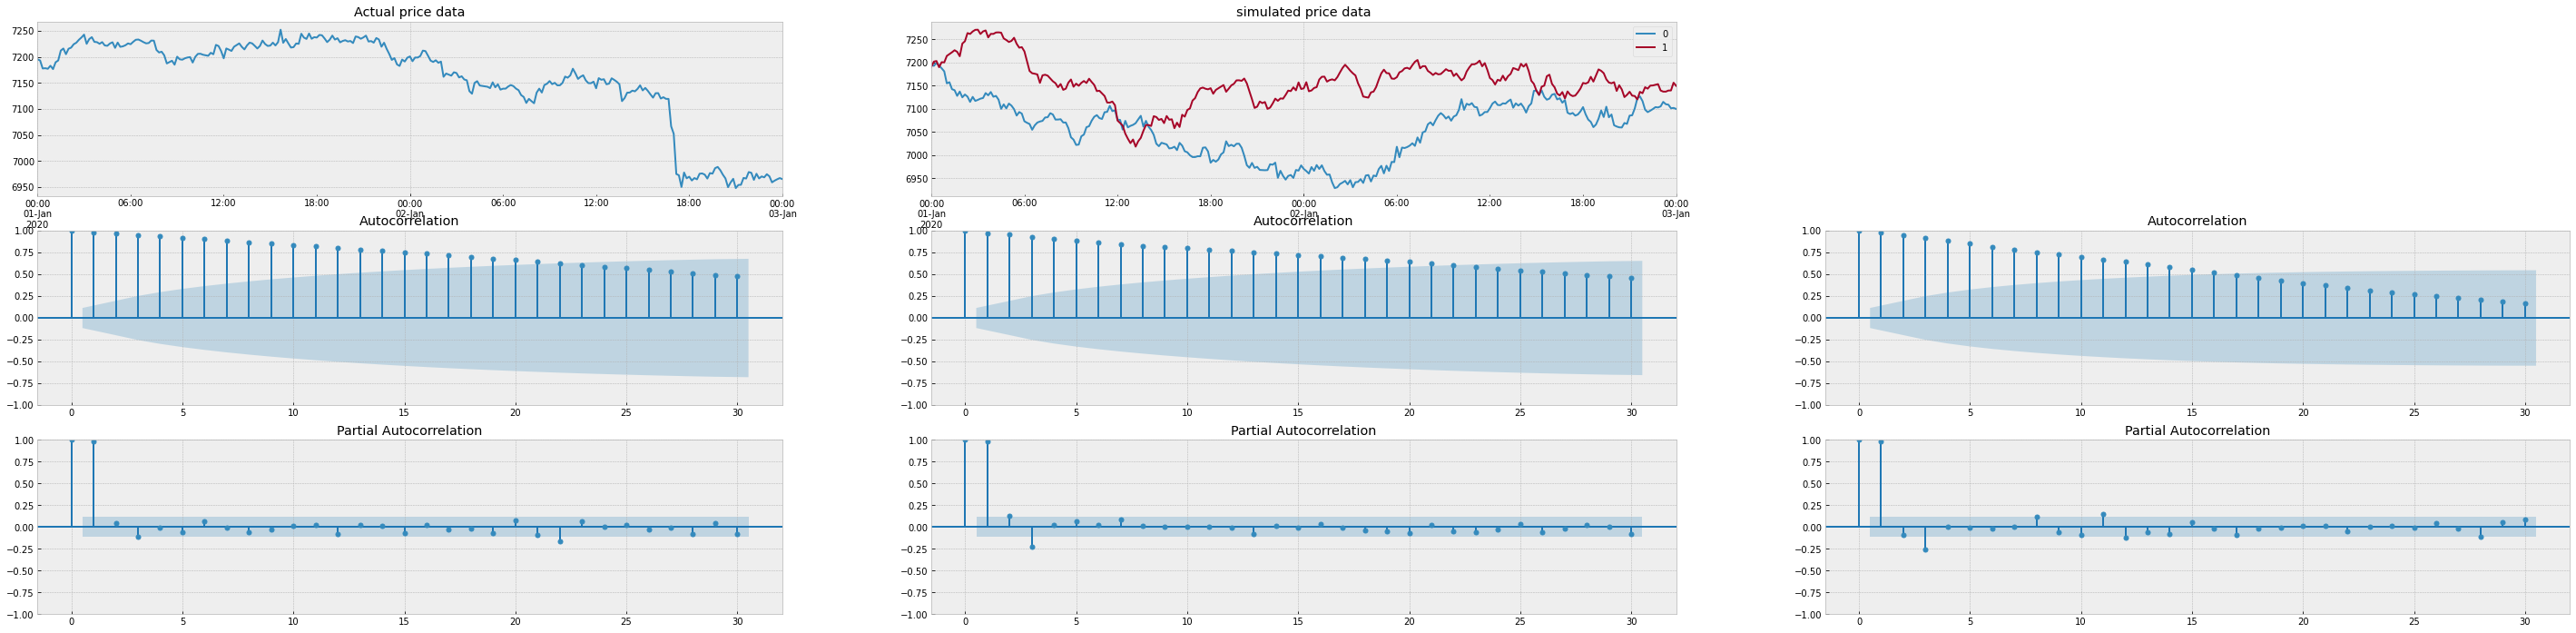

In [21]:
simulatedata.Evaluate_performance(dt['open'], simulated_price_data, lags=30)

# End

In [22]:
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()


# dt1.corr bị thành null matrix nên lúc trước tôi để thành dt để test và dt thì nó hiển nhiên ko đúng but ko biết làm 
# thế nào để fix cho cái dt1 nó ko bị null mặc dù cho chạy thẳng hàm cholesky.cholesky2 thì cũng có đoạn tính corr dt1 mà nó ko bị null
cov_open_close = dt1.corr()
cov = cov_open_close[0][0] / var_close * var_open
cov, var_open

KeyError: 0

In [ ]:
data1 = []
data1 = np.append(data1, simulate_multiple_time_series.normalize_or_standardize_data(dt1['open'], is_normalize= False))
data2 = pd.DataFrame()
data2['close'] = dt1['close']-mean_close
for i in range(len(data2['close'])):
    data2['close'][i] = data2['close'][i] * 2 * cov_open_close[0][0] * var_open/var_close
data3 = pd.DataFrame()
data3['open'] = dt1['open']
data3['close'] = -data2['close']+ dt1['open']
chol = np.linalg.cholesky(data3.corr())
inverse_chol = np.linalg.inv(chol)
data1 = np.append(data1, data3['close'])
data1 = data1.reshape(2, len(dt1['close']))
data1 = np.matmul(inverse_chol, data1)
transform = pd.DataFrame(dt1).copy()
transform['close'] = data1[1]
transform['open'] = data1[0]
transform, simulate_multiple_time_series.compute_std(transform['close']),simulate_multiple_time_series.compute_std(transform['open'])

In [ ]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
array = []
array = np.append(array, transform_x_chol['open'])
array = np.append(array, transform_x_chol['close'])
array = array.reshape(2,len(transform_x_chol['open']))
transform_back = np.matmul(chol, array)
# simulate_corr_rets['close'] = simulate_corr_rets['open'] - simulate_corr_rets['close']
simulate = pd.DataFrame()
simulate['open'] =simulate_multiple_time_series.mulback_cholesky(transform_back[0],  False, mean_open, var_open)
simulate['close'] = simulate_multiple_time_series.mulback_cholesky(transform_back[0] -transform_back[1],  False, mean_close, var_close/(2*cov))
# simulate ['close'] = simulate['open']-simulate['close']
simulate
# transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close/(2*cov), mean_close, var_open, mean_open)
# transform_back

In [ ]:
simulate.corr()

In [ ]:
dt1.corr()

In [ ]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(simulate['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(simulate['close'], dt['close'][0], dt.index[0], freq)
# for i in range(len(simulated_price_data[1])):
#     simulated_price_data[1][i]=simulated_price_data[1][i] * simulated_price_data[0][i]
simulated_price_data

In [ ]:
simulatedata.Evaluate_performance(dt['open'], simulated_price_data, lags=30)

In [ ]:
dt.plot()

In [ ]:
simulate_multiple_time_series.simulate_open_and_close(dt)

In [ ]:
# order, seasonal_order = simulatedata.get_order(dt['open'][1:])
# order, seasonal_order

In [ ]:
# if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
# model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
# t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
# t

In [ ]:
# simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
# simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)